## Identifying Duplicate Questions

Over 100 million people visit Quora every month, so it's no surprise that many people ask similar (or the same) questions. Various questions with the same intent can cause people to spend extra time searching for the best answer to their question, and results in members answering multiple versions of the same question. Quora uses random forest to identify duplicated questions to provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.
Follow the steps outlined below to build the appropriate classifier model. 


Steps:
- Download data
- Exploration
- Cleaning
- Feature Engineering
- Modeling

By the end of this project you should have **a presentation that describes the model you built** and its **performance**. 


In [42]:
import pandas as pd
import numpy as np

In [43]:
df = pd.read_csv("train.csv")

In [44]:
df.shape

(404290, 6)

In [45]:
df.qid1.nunique()

290654

In [46]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [47]:
# drop missing questions 
df.dropna(inplace=True)
print(df.isna().sum())

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64


#### Note
There is no designated test.csv file. The train.csv file is the entire dataset. Part of the data in the train.csv file should be set aside to act as the final testing data.

In [48]:
df_test = df.groupby('is_duplicate', group_keys=False).apply(lambda x : x.sample(frac=0.3)).reset_index(drop=True)
df_train = df[~df.index.isin(df_test.index)].reset_index(drop=True)

In [49]:
print(df_test.shape)
print(df_train.shape)

(121286, 6)
(283002, 6)


In [50]:
print(df_test['is_duplicate'].value_counts(normalize=True))
print(df_train['is_duplicate'].value_counts(normalize=True))

0    0.630798
1    0.369202
Name: is_duplicate, dtype: float64
0    0.631999
1    0.368001
Name: is_duplicate, dtype: float64


### Exploration

In [51]:
df_train.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,121286,196563,177221,Why do so many Americans hate Donald Trump?,Why do most of the Americans and other countri...,1
1,121287,196564,123668,What Is adam apple?,What does an Adam's Apple feel like?,0
2,121288,196565,196566,Can you laminate a social security card?,Can I laminate my social security card?,1
3,121289,196567,101462,How do I find wearables manufacturers in Asia ...,I have a design for an electronic product. How...,0
4,121290,196568,196569,What steps can the government and people of In...,What can America learn from India?,0


In [52]:
# median, max and min characters in a question
print(df_train['question1'].apply(len).median())
print(df_train['question1'].apply(len).max())
print(df_train['question1'].apply(len).min())

52.0
430
1


In [53]:
print(df_train['question2'].apply(len).median())
print(df_train['question2'].apply(len).max())
print(df_train['question2'].apply(len).min())

51.0
1169
1


In [54]:
q1_train = df_train['question1']
q2_train = df_train['question2']

In [55]:
q1_train[q1_train.str.contains('http')]

27470     Should I use the java.net or org.apache.http l...
30704     Https://www.change.org/p/https-w... ALL TORREN...
57187     If Express.js 4.0 no longer uses Connect, (whi...
77891     Why does Google Chrome shows cross & red marks...
109271    What is the diference between $http.get and $h...
135213    What is difference between http and https in w...
164697    Why do I get unhandled promise rejection while...
189478    How do I set timeout for http post request usi...
195173         Why does http change automatically to https?
227489                What are the primary defects of http?
263948    How safe/risky is it to use an https connectio...
Name: question1, dtype: object

### Cleaning

- Tokenization
- Stopwords cleaning
- Removing punctuation
- Normalizing
- Stemming

In [56]:
import re

from nltk.corpus import stopwords
engStopWords = stopwords.words('english')

import string
puncts = string.punctuation

from nltk import WordNetLemmatizer
lemmatizer=WordNetLemmatizer()

In [57]:
# remove addition for math questions ?
puncts2 = """!"#$%&\'()*,.:;<=>?@[\\]_`{|}~"""

In [58]:
puncts

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [59]:
def del_stopWords(text):
    word_list = text.split()
    text =" ".join([word for word in word_list if word not in engStopWords])
    return text

def del_punct(text):
    text="".join([char for char in text if char not in puncts])
    return text

def lem_text(text):
    word_list = text.split()
    text=" ".join([lemmatizer.lemmatize(word) for word in word_list])
    return text


In [60]:
def preprocess_text(text_list):
    text_clean=[]
    for text in text_list:
        text = text.lower()
        text = re.sub(r'https?://\S+|www\.\S+', '', text) # remove urls
        text = re.sub(r'<.*?>', '', text) # remove htmls
        text = del_punct(text)
        text = del_stopWords(text)
        text = lem_text(text)
        text = re.sub(r'\s+', ' ', text).strip()
        text_clean.append(text)
    return text_clean

In [61]:
q1_train_clean = preprocess_text(q1_train)

In [62]:
print(q1_train[3])
print(q1_train_clean[3])

How do I find wearables manufacturers in Asia that are reliable, and do all the testing that electronic products require?
find wearable manufacturer asia reliable testing electronic product require


In [63]:
q2_train_clean = preprocess_text(q2_train)

In [64]:
print(q2_train[20])
print(q2_train_clean[20])

How can you learn graphic designing?
learn graphic designing


In [65]:
df_train['q1_clean'] = q1_train_clean
df_train['q2_clean'] = q2_train_clean

### EDA 

### Feature Engineering

- tf-idf
- word2vec
- word count
- number of the same words in both questions
- ....

In [66]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

In [67]:
df_train.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_clean,q2_clean
0,121286,196563,177221,Why do so many Americans hate Donald Trump?,Why do most of the Americans and other countri...,1,many american hate donald trump,american country citizen hate donald trump
1,121287,196564,123668,What Is adam apple?,What does an Adam's Apple feel like?,0,adam apple,adam apple feel like
2,121288,196565,196566,Can you laminate a social security card?,Can I laminate my social security card?,1,laminate social security card,laminate social security card
3,121289,196567,101462,How do I find wearables manufacturers in Asia ...,I have a design for an electronic product. How...,0,find wearable manufacturer asia reliable testi...,design electronic product get manufactured chu...
4,121290,196568,196569,What steps can the government and people of In...,What can America learn from India?,0,step government people india take ensure healt...,america learn india


In [68]:
# def tokenize(text):
#     return text.split()

In [69]:
tf_vectorizer = TfidfVectorizer(max_features=1000, analyzer='word', use_idf=True, min_df=5, max_df=0.8)

In [70]:
questions = q1_train_clean + q2_train_clean

In [71]:
tf_vectorizer.fit(questions)
# tf_data_q2 = tf_vectorizer.fit_transform(q2_train_clean).toarray()

TfidfVectorizer(max_df=0.8, max_features=1000, min_df=5)

In [72]:
q1_vect = tf_vectorizer.transform(q1_train_clean)
q2_vect = tf_vectorizer.transform(q2_train_clean)

In [73]:
df_q1_vect = pd.DataFrame(q1_vect.toarray()).add_prefix('q1_')

In [74]:
df_q1_vect.head()

,q1_0,q1_1,q1_2,q1_3,q1_4,q1_5,q1_6,q1_7,q1_8,q1_9,...,q1_990,q1_991,q1_992,q1_993,q1_994,q1_995,q1_996,q1_997,q1_998,q1_999
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [75]:
df_q2_vect = pd.DataFrame(q2_vect.toarray()).add_prefix('q2_')

In [76]:
df_vect = pd.concat([df_q1_vect, df_q2_vect], axis=1)

In [77]:
df_vect.shape

(283002, 2000)

In [78]:
y = df_train['is_duplicate']

In [79]:
y.shape

(283002,)

In [80]:
from sklearn.model_selection import train_test_split

In [81]:
X_train, X_test, y_train, y_test = train_test_split(df_vect, y, test_size=0.2, random_state=15)

In [82]:
# tf_data.shape

In [83]:
# tf_data

In [84]:
# tf_data = np.concatenate((tf_data_q1,tf_data_q2), axis=1)

In [85]:
# df_train.shape

In [86]:
# tf_data_q1.shape

In [87]:
# tf_data_q2.shape

In [88]:
# train_data = np.concatenate((tf_data_q1, tf_data_q2), axis=1)

In [89]:
# df_q1_tf = pd.DataFrame(tf_data_q1)
# df_q1_tf.head()

In [90]:
# df_q2_tf = pd.DataFrame(tf_data_q2)
# df_q2_tf.head()

In [91]:
# df_train_tf = pd.concat([df_q1_tf, df_q2_tf], axis=1)

In [92]:
# df_train_tf.head()

### Modeling

Different modeling techniques can be used:

- logistic regression
- XGBoost
- LSTMs
- etc

In [93]:
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [94]:
logR = LogisticRegression()

In [95]:
logR.fit(X_train, y_train)

/opt/homebrew/Caskroom/miniforge/base/envs/lhl_env38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [96]:
yhat = logR.predict(X_test)

In [97]:
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix

In [98]:
accuracy_score(y_test, yhat)

0.711718874224837

In [99]:
# rfc = RandomForestClassifier(max_depth=10, n_jobs=-1, random_state=15)

In [100]:
# rfc.fit(X_train, y_train)

In [101]:
xgbC = XGBClassifier(learning_rate=0.01)

In [102]:
xgbC.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [103]:
yhat_xg = xgbC.predict(X_test)

In [104]:
accuracy_score(y_test, yhat_xg)

0.6703061783360718

In [105]:
confusion_matrix(y_test, yhat_xg)

array([[33727,  2016],
       [16645,  4213]])

In [106]:
from sklearn.naive_bayes import GaussianNB

In [107]:
gnb = GaussianNB()

In [108]:
gnb.fit(X_train, y_train)

GaussianNB()

In [109]:
yhat_gnb = gnb.predict(X_test)

In [110]:
accuracy_score(y_test, yhat_gnb)

0.6338933941096447

In [111]:
xgbC2 = XGBClassifier(
    max_depth=10, learning_rate=0.1,
    colsample_bytree=0.3, n_estimators=200)

In [112]:
xgbC2.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.3,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=10, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=200,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [113]:
yhat_xg2 = xgbC2.predict(X_test)

In [114]:
accuracy_score(y_test, yhat_xg2)

0.7314888429533047

In [115]:
cm = confusion_matrix(y_test, yhat_xg2)

In [127]:
tn, fp, fn, tp = confusion_matrix(y_test, yhat_xg2).ravel()

In [128]:
(tn, fp, fn, tp)

(33814, 1929, 13269, 7589)

In [116]:
import matplotlib.pyplot as plt
import seaborn as sns

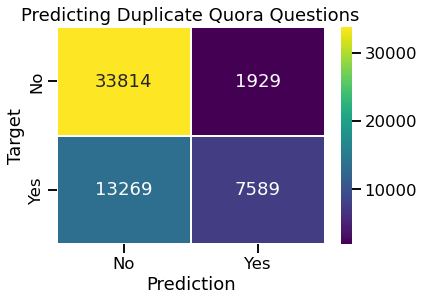

<Figure size 432x288 with 0 Axes>

In [130]:
with sns.plotting_context('talk'):
    ax = sns.heatmap(cm, annot=True, cmap='viridis', linewidths=2, linecolor='white', fmt=".0f")
    plt.xlabel('Prediction')
    ax.set_xticklabels(['No','Yes'])
    ax.set_yticklabels(['No','Yes'])
    plt.ylabel('Target')
    plt.title('Predicting Duplicate Quora Questions')
    plt.show()
    plt.savefig('confusion_matrix.png')

In [124]:
from sklearn.metrics import classification_report

In [126]:
print(classification_report(y_test, yhat_xg2))

              precision    recall  f1-score   support

           0       0.72      0.95      0.82     35743
           1       0.80      0.36      0.50     20858

    accuracy                           0.73     56601
   macro avg       0.76      0.65      0.66     56601
weighted avg       0.75      0.73      0.70     56601

